# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [5]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets as ds
from scipy.stats import randint
from zipfile import ZipFile

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import preprocessing

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [23]:
#Learning curve
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

In [59]:
# Data loading functions

def preprocessing_data(data, n_features=2):
    data_points= data.drop(['label'], axis=1).to_numpy()
    data_labels= data['label'].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(data_points, data_labels, test_size=0.3)

    #Scaling
    scaler = preprocessing.QuantileTransformer(578)
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #PCA
    pca = PCA(n_components=n_features)
    pca = pca.fit(x_train_scaled)
    x_train_trans = pca.transform(x_train_scaled)
    x_test_trans = pca.transform(x_test_scaled)

    # x_train_trans_df = pd.DataFrame(x_train_trans, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    # y_train_df = pd.DataFrame(y_train, columns=['label'])
    # xy_plot = pd.concat([x_train_trans_df, y_train_df], axis=1)
    # pc_pairplot = sns.pairplot(xy_plot, hue='label', palette='tab10')
    
    return x_train_trans, y_train, x_test_trans, y_test



In [86]:
# Load data and create classifiers

# Data
from ecg.load_data import load_data
data = load_data()

x_train_trans, y_train, x_test_trans, y_test = preprocessing_data(data, 2)
X = x_train_trans
Y = y_train

# Classifiers
# param_distributions_svm = {}
# param_distributions = {'n_estimators': randint(1, 400)}
# svmlin = RandomizedSearchCV(SVC(kernel='linear', gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# svmrbf = RandomizedSearchCV(SVC(kernel='rbf', gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# svmpoly = RandomizedSearchCV(SVC(kernel='poly', degree=3, gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# RF = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)
# LDA = RandomizedSearchCV(LinearDiscriminantAnalysis(), param_distributions, cv=5, n_iter=20, random_state=42)
# KNN = RandomizedSearchCV(KNeighborsClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)
# clsfs = [svmlin,svmrbf,svmpoly,RF,LDA,KNN]
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]


C:\Users\sanne\miniconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_quantiles=578 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\sanne\miniconda3\lib\site-packages\skle

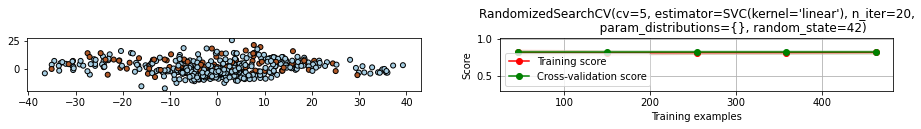

In [84]:
# Learning Curve

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
num = 1
for clf in clsfs:
    # Split data in training and testing
    title = str(clf)
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X, Y, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1

In [87]:
# Plot classifications

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

num = 1
for clf in clsfs:
    clf.fit(X, Y)
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(x_test_trans)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    best = clf.best_estimator_
    t = ('Misclassified: %d / %d, %d' % ((y_test != y_pred).sum(), x_test_trans.shape[0], accuracy*100), str(clf))
    ax.set_title(t)
    print(best)
    num += 1




C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
SVC(kernel='linear')
SVC()
SVC(kernel='poly')
C:\Users\sanne\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
RandomForestClassifier(n_estimators=373)


ValueError: Invalid parameter n_estimators for estimator LinearDiscriminantAnalysis(). Check the list of available parameters with `estimator.get_params().keys()`.

In [88]:
for param in LDA.get_params().keys():
    print(param)

cv
error_score
estimator__n_components
estimator__priors
estimator__shrinkage
estimator__solver
estimator__store_covariance
estimator__tol
estimator
iid
n_iter
n_jobs
param_distributions
pre_dispatch
random_state
refit
return_train_score
scoring
verbose
